In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import svm
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from collections import Counter

In [2]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


In [3]:
dataset = pd.read_excel('corona_dataset.xlsx')

## Pre-processing 

In [4]:
# Adding colunm indicates if person has symptoms or not - 

dataset.loc[:,'has_atleast_one_symptom'] = dataset['cough']+dataset['fever']+dataset['sore_throat']+dataset['shortness_of_breath']+dataset['head_ache']
dataset['has_atleast_one_symptom'].loc[dataset['has_atleast_one_symptom'] > 0] = 1
dataset['has_atleast_one_symptom'] = dataset['has_atleast_one_symptom'].fillna(0)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# Remove samples with corona_result as 'אחר' -
dataset = dataset[dataset.corona_result != 'אחר']  # remove 1391 observations

# Changing some value's name
to_replace_1 = 'חיובי'
dataset = dataset.replace(to_replace_1,1)

to_replace_0 = 'שלילי'
dataset = dataset.replace(to_replace_0,0)

dataset = dataset.replace(['זכר', 'נקבה'],['female','male'])

dataset['cough'] = dataset['cough'].replace([1,0],['Yes','No'])
dataset['fever'] = dataset['fever'].replace([1,0],['Yes','No'])

In [6]:
# Remove samples with no age indications -

data = dataset[~dataset['age_60_and_above'].isnull()]
data['age_60_and_above'] = data['age_60_and_above'].replace(['Yes','No'],[1,0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Only positive records to Corona - population by age

In [7]:
positive_data = data[data['corona_result'] == 1] # 9937 records with a positive diagnosis

In [8]:
features = ['cough','fever','sore_throat','shortness_of_breath','head_ache','gender','test_indication']
ground_truth = positive_data['age_60_and_above'] # 1936 records above 60 years old
tsne_data = positive_data[features]

In [9]:
# One Hot Encoding before t-SNE - 

tsne_data_dummies = pd.get_dummies(tsne_data[features],dummy_na=False, drop_first=False)
tsne_data_dummies

,sore_throat,shortness_of_breath,head_ache,cough_No,cough_Yes,fever_No,fever_Yes,gender_female,gender_male,test_indication_Abroad,test_indication_Contact with confirmed,test_indication_Other
4507,0.0,0.0,1.0,0,1,0,1,0,0,1,0,0
4519,0.0,0.0,0.0,1,0,0,1,0,0,1,0,0
4520,0.0,0.0,1.0,1,0,1,0,0,0,0,1,0
4524,0.0,0.0,0.0,0,1,0,1,0,0,0,1,0
4543,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
125935,0.0,0.0,0.0,1,0,0,1,1,0,0,0,1
125951,0.0,0.0,0.0,1,0,1,0,1,0,0,0,1
125967,0.0,0.0,0.0,1,0,1,0,0,0,0,0,1
125993,0.0,0.0,0.0,1,0,1,0,0,1,0,0,1


### classification

In [10]:
X = tsne_data_dummies
Y = ground_truth
class_weights = get_class_weights(Y)
class_weights

{0: 1.0, 1: 4.13}

In [11]:
# Seperation with class weights - 
clf = svm.SVC(kernel='linear',gamma='auto', class_weight=class_weights)
clf = clf.fit(X,Y)

predictions = clf.predict(X)

### Dimentionality reduction - t-SNE

In [12]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import time 

time_start = time.time()
tsne = TSNE (n_components=2, n_jobs=-1)
tsne_embedding = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 118.44826817512512 seconds


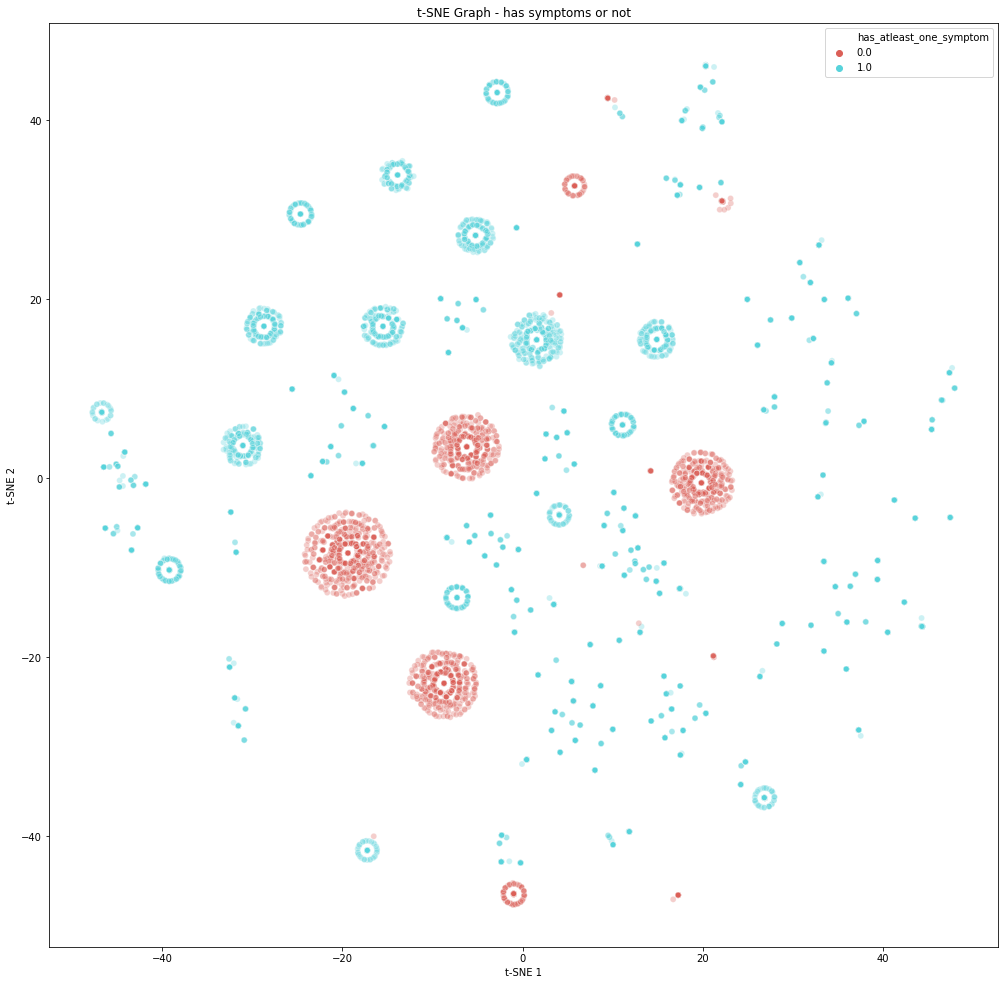

In [13]:
# colors by records with symptoms (red) and no symptoms (green) - 

plt.figure(figsize=(17,17))
#c = ['red' if c==1 else 'green' for c in data['has_atleast_one_symptom']]
#s = [15 if c==1 else 15 for c in data['has_atleast_one_symptom']]
sns.scatterplot(tsne_embedding[:,0], tsne_embedding[:,1], hue=positive_data['has_atleast_one_symptom'], palette=sns.color_palette("hls", 2),legend="full",alpha=0.3)
plt.title('t-SNE Graph - has symptoms or not')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne_by_symptoms.png')

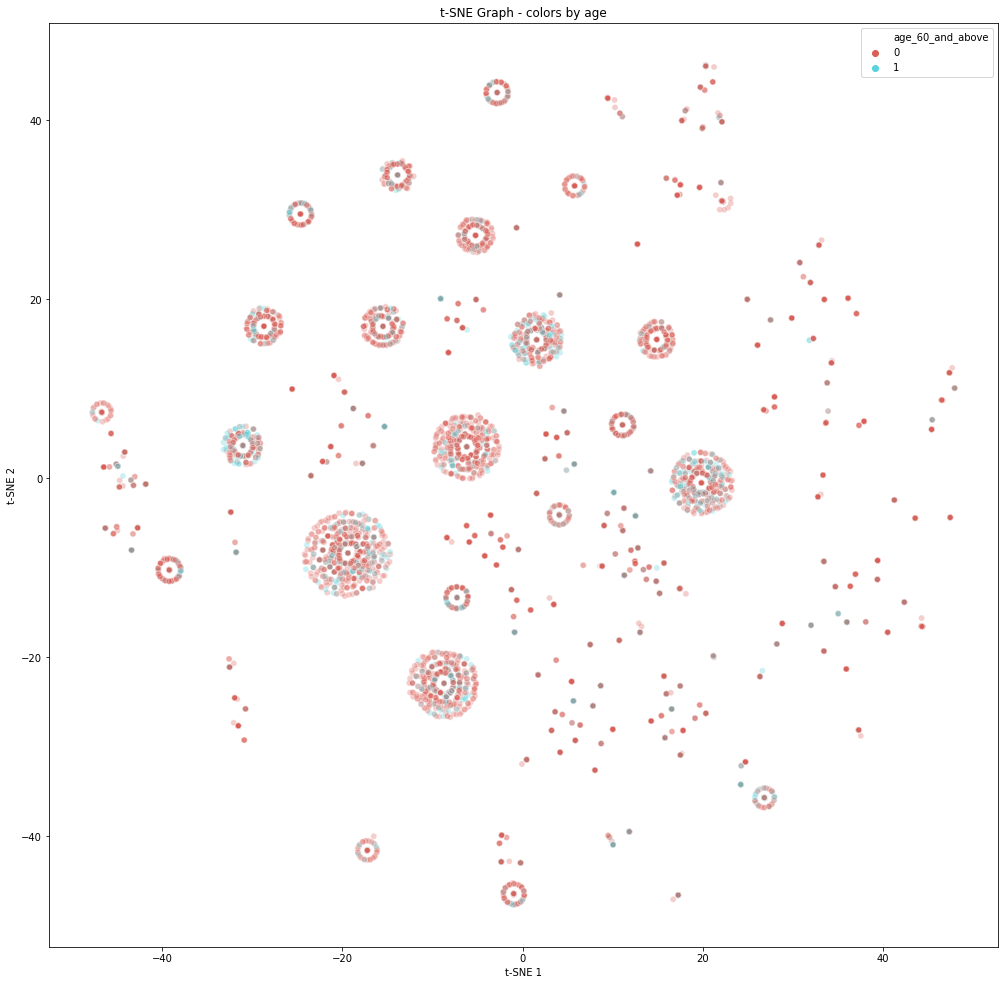

In [14]:
# colors by age - 

plt.figure(figsize=(17,17))
c = ['red' if c==1 else 'green' for c in ground_truth]
s = [15 if c==1 else 15 for c in ground_truth]
#plt.scatter(tsne_embedding[:,0],tsne_embedding[:,1], c=c,s=s)
sns.scatterplot(tsne_embedding[:,0], tsne_embedding[:,1], hue=ground_truth, palette=sns.color_palette("hls", 2),legend="full",alpha=0.3)
plt.title('t-SNE Graph - colors by age')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne_by_age.png')

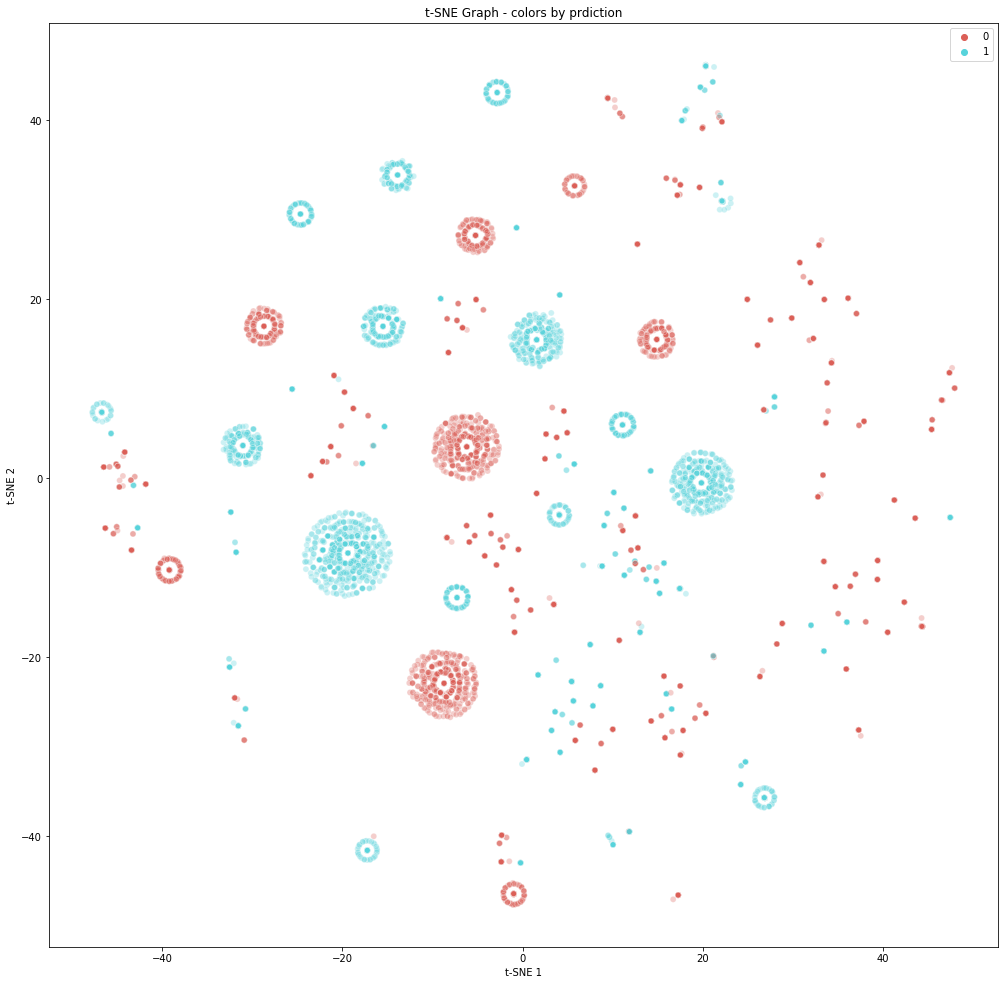

In [15]:
# colors after division to population by age - 

plt.figure(figsize=(17,17))
c = ['red' if c==1 else 'green' for c in predictions]
s = [15 if c==1 else 15 for c in predictions]
#plt.scatter(tsne_embedding[:,0],tsne_embedding[:,1], c=c,s=s)
sns.scatterplot(tsne_embedding[:,0], tsne_embedding[:,1], hue=predictions, palette=sns.color_palette("hls", 2),legend="full",alpha=0.3)

plt.title('t-SNE Graph - colors by prdiction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne_by_predictions.png')

### Only predictions whose prediction was over 60 years - 

In [27]:
X_new = X[predictions == 1]
Y_new = Y[predictions == 1]

class_weights = get_class_weights(Y_new)
class_weights

{1: 2.97, 0: 1.0}

In [28]:
# Seperation with class weights - 
clf = svm.SVC(kernel='linear',gamma='auto', class_weight=class_weights)
clf = clf.fit(X_new,Y_new)

predictions1 = clf.predict(X_new)

In [29]:
len(predictions1)

5020

In [30]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import time 

time_start = time.time()
tsne_1 = TSNE (n_components=2, n_jobs=-1)
tsne1_embedding = tsne_1.fit_transform(X_new)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 55.07170581817627 seconds


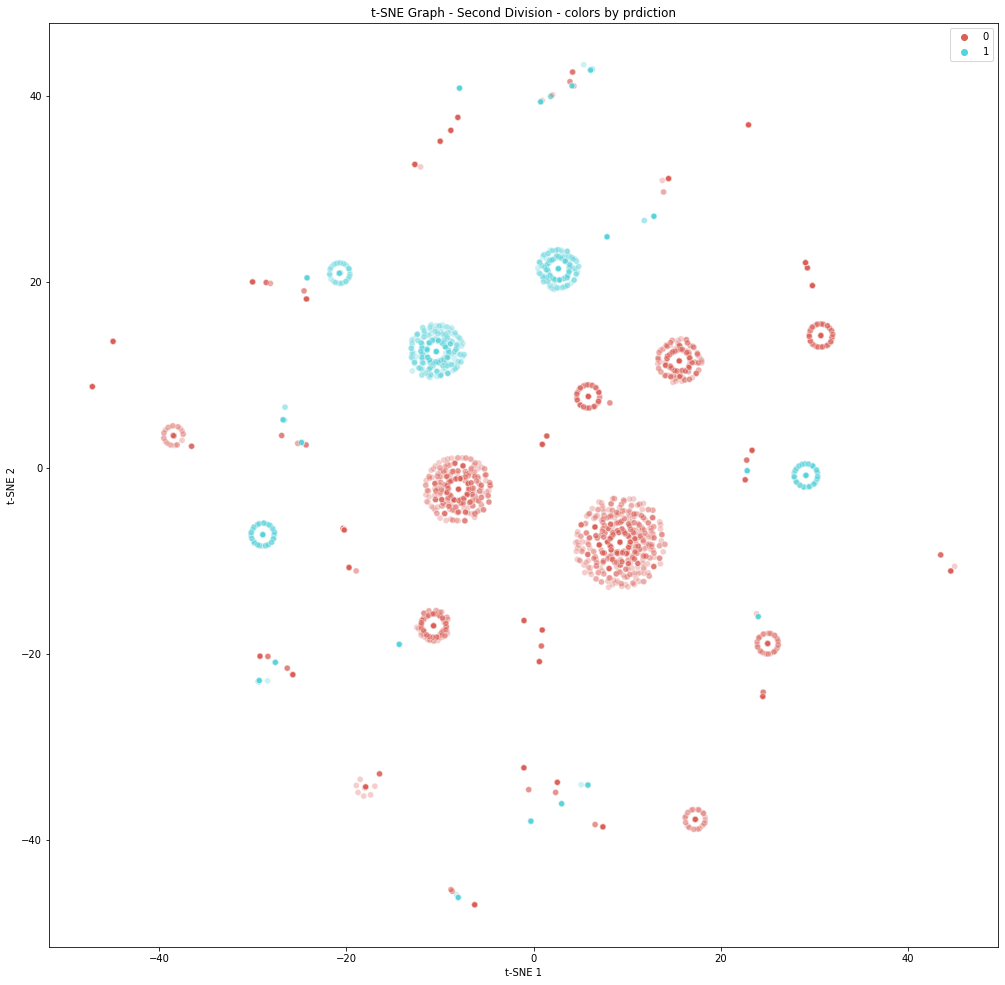

In [33]:
# colors after division to population by age - 

plt.figure(figsize=(17,17))
sns.scatterplot(tsne1_embedding[:,0], tsne1_embedding[:,1], hue=predictions1, palette=sns.color_palette("hls", 2),legend="full",alpha=0.3)

plt.title('t-SNE Graph - Second Division - colors by prdiction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne1_by_predictions.png')

### Only predictions whose prediction1 was over 60 years - 

In [35]:
X_new = X_new[predictions1 == 1]
Y_new = Y_new[predictions1 == 1]
class_weights = get_class_weights(Y_new)

# Seperation with class weights - 
clf = svm.SVC(kernel='linear',gamma='auto', class_weight=class_weights)
clf = clf.fit(X_new,Y_new)

predictions2 = clf.predict(X_new)

In [36]:
time_start = time.time()
tsne_2 = TSNE (n_components=2, n_jobs=-1)
tsne2_embedding = tsne_2.fit_transform(X_new)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 16.533835649490356 seconds


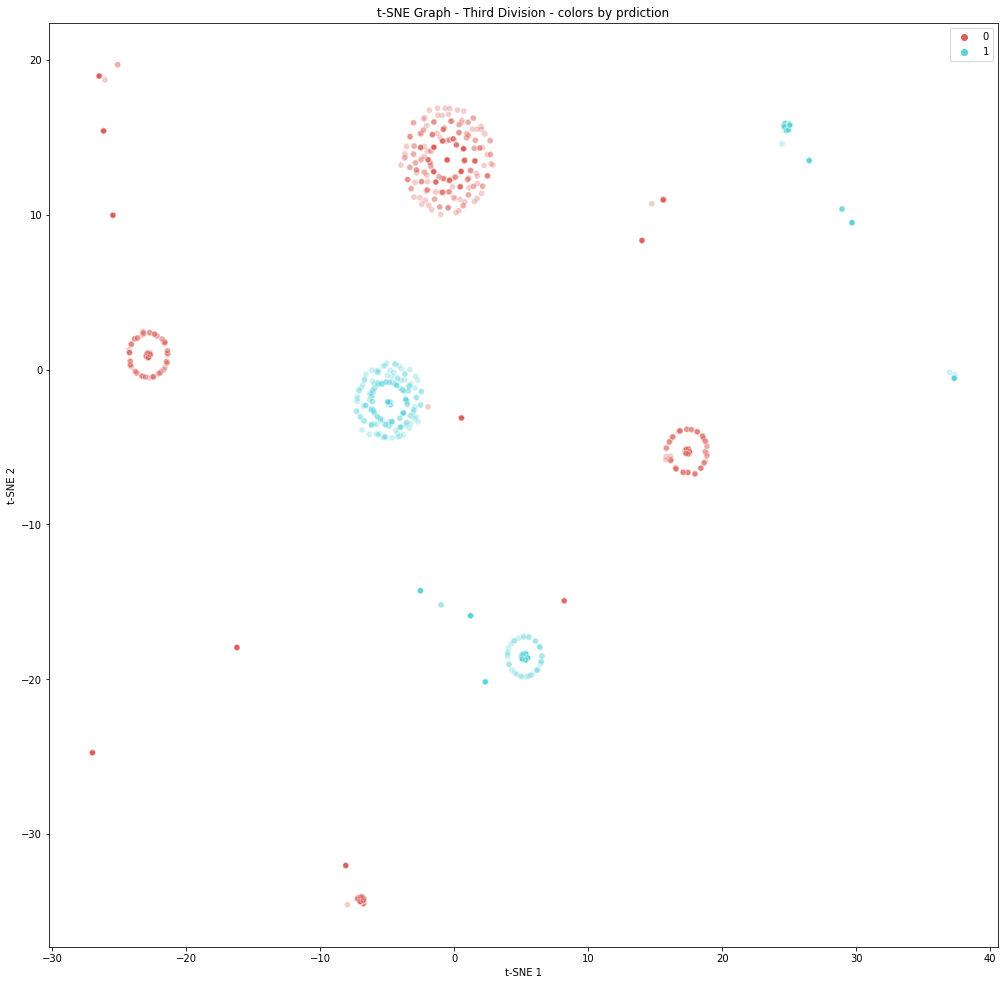

In [37]:
# colors after division to population by age - 

plt.figure(figsize=(17,17))
sns.scatterplot(tsne2_embedding[:,0], tsne2_embedding[:,1], hue=predictions2, palette=sns.color_palette("hls", 2),legend="full",alpha=0.3)

plt.title('t-SNE Graph - Third Division - colors by prdiction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne2_by_predictions.png')

### Only predictions whose prediction2 was over 60 years - 

In [38]:
X_new = X_new[predictions2 == 1]
Y_new = Y_new[predictions2 == 1]
class_weights = get_class_weights(Y_new)

# Seperation with class weights - 
clf = svm.SVC(kernel='linear',gamma='auto', class_weight=class_weights)
clf = clf.fit(X_new,Y_new)

predictions3 = clf.predict(X_new)

In [39]:
time_start = time.time()
tsne_3 = TSNE (n_components=2, n_jobs=-1)
tsne3_embedding = tsne_3.fit_transform(X_new)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 9.482045888900757 seconds


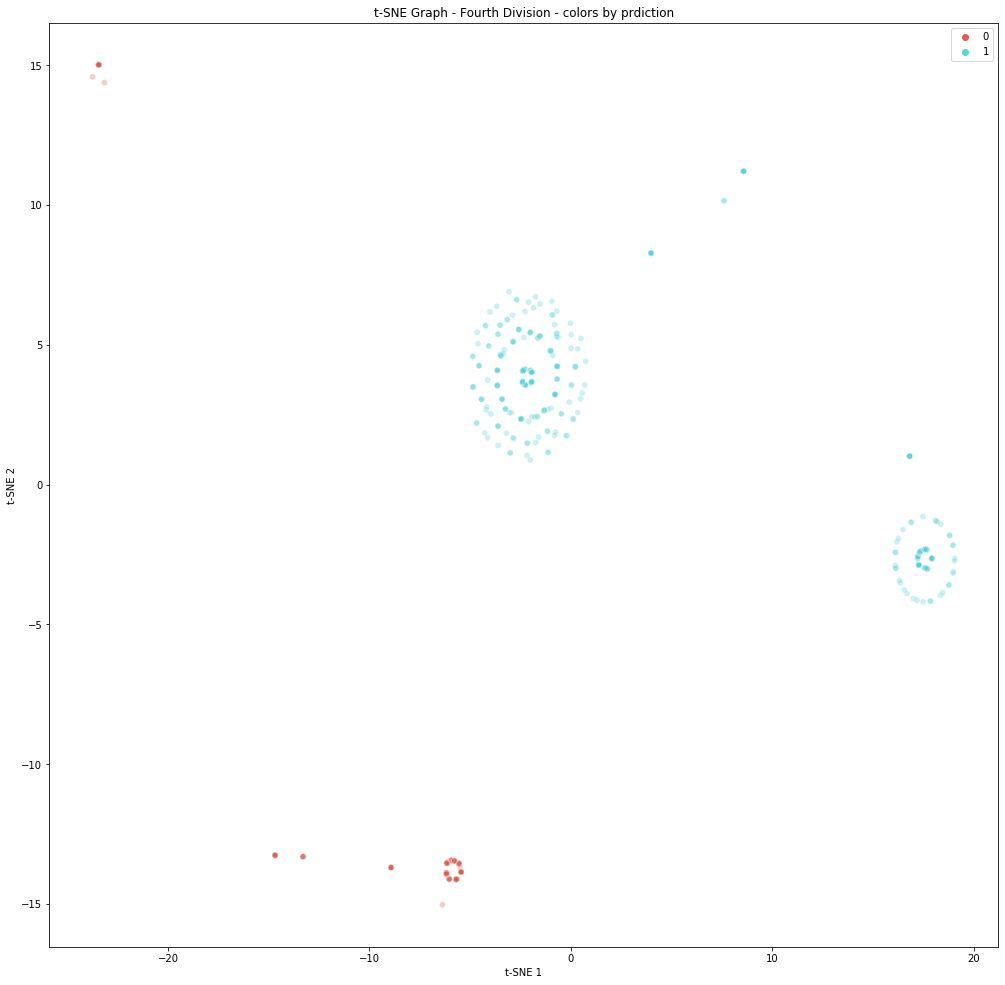

In [40]:
# colors after division to population by age - 

plt.figure(figsize=(17,17))
sns.scatterplot(tsne3_embedding[:,0], tsne3_embedding[:,1], hue=predictions3, palette=sns.color_palette("hls", 2),legend="full",alpha=0.3)

plt.title('t-SNE Graph - Fourth Division - colors by prdiction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne3_by_predictions.png')

### Only predictions whose prediction3 was over 60 years - 

In [41]:
X_new = X_new[predictions3 == 1]
Y_new = Y_new[predictions3 == 1]
class_weights = get_class_weights(Y_new)

# Seperation with class weights - 
clf = svm.SVC(kernel='linear',gamma='auto', class_weight=class_weights)
clf = clf.fit(X_new,Y_new)

predictions4 = clf.predict(X_new)

In [45]:
accuracy = accuracy_score(Y_new, predictions4)
error_rate = 1 - accuracy
error_rate

0.3691275167785235

In [42]:
time_start = time.time()
tsne_4 = TSNE (n_components=2, n_jobs=-1)
tsne4_embedding = tsne_4.fit_transform(X_new)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 5.3139238357543945 seconds


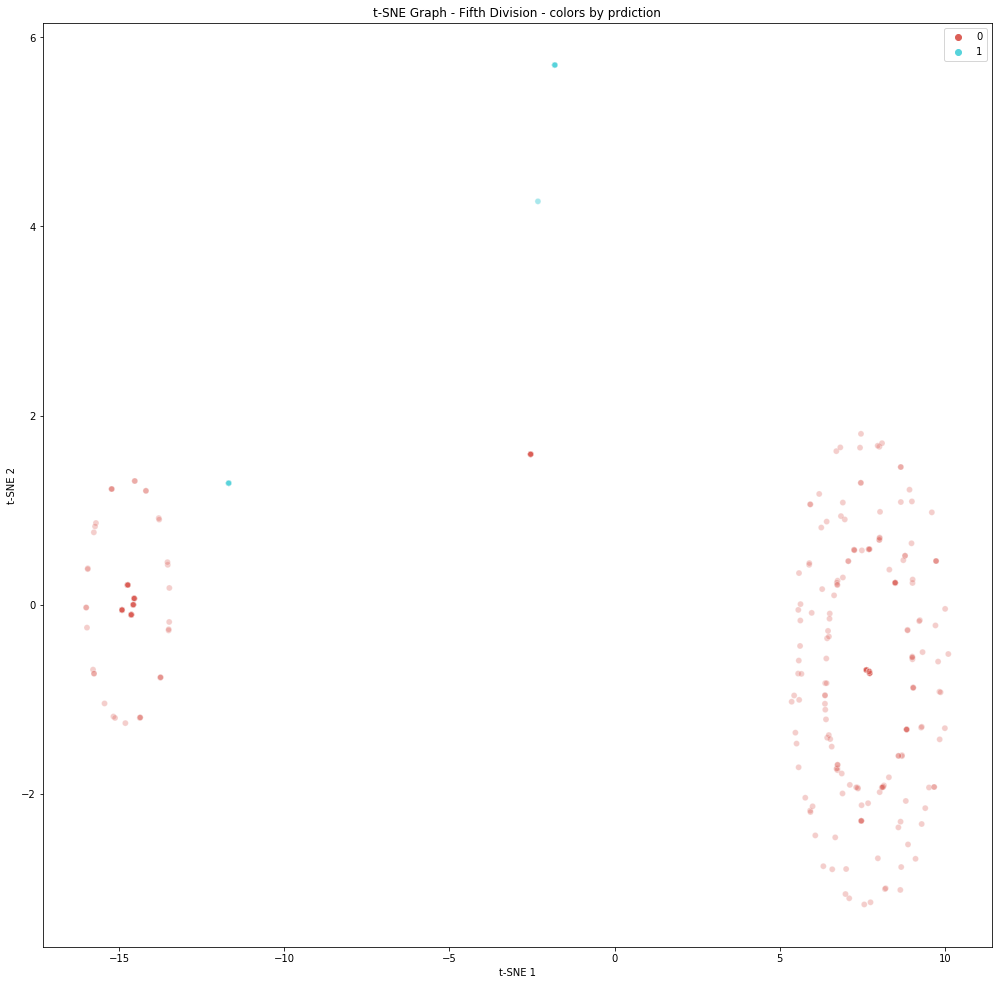

In [43]:
# colors after division to population by age - 

plt.figure(figsize=(17,17))
sns.scatterplot(tsne4_embedding[:,0], tsne4_embedding[:,1], hue=predictions4, palette=sns.color_palette("hls", 2),legend="full",alpha=0.3)

plt.title('t-SNE Graph - Fifth Division - colors by prdiction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne4_by_predictions.png')

In [46]:
X_new = X_new[predictions4 == 1]
Y_new = Y_new[predictions4 == 1]
class_weights = get_class_weights(Y_new)

# Seperation with class weights - 
clf = svm.SVC(kernel='linear',gamma='auto', class_weight=class_weights)
clf = clf.fit(X_new,Y_new)

predictions5 = clf.predict(X_new)

In [47]:
accuracy = accuracy_score(Y_new, predictions5)
error_rate = 1 - accuracy
error_rate

0.4722222222222222

In [48]:
time_start = time.time()
tsne_5 = TSNE (n_components=2, n_jobs=-1)
tsne5_embedding = tsne_5.fit_transform(X_new)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 0.10420894622802734 seconds


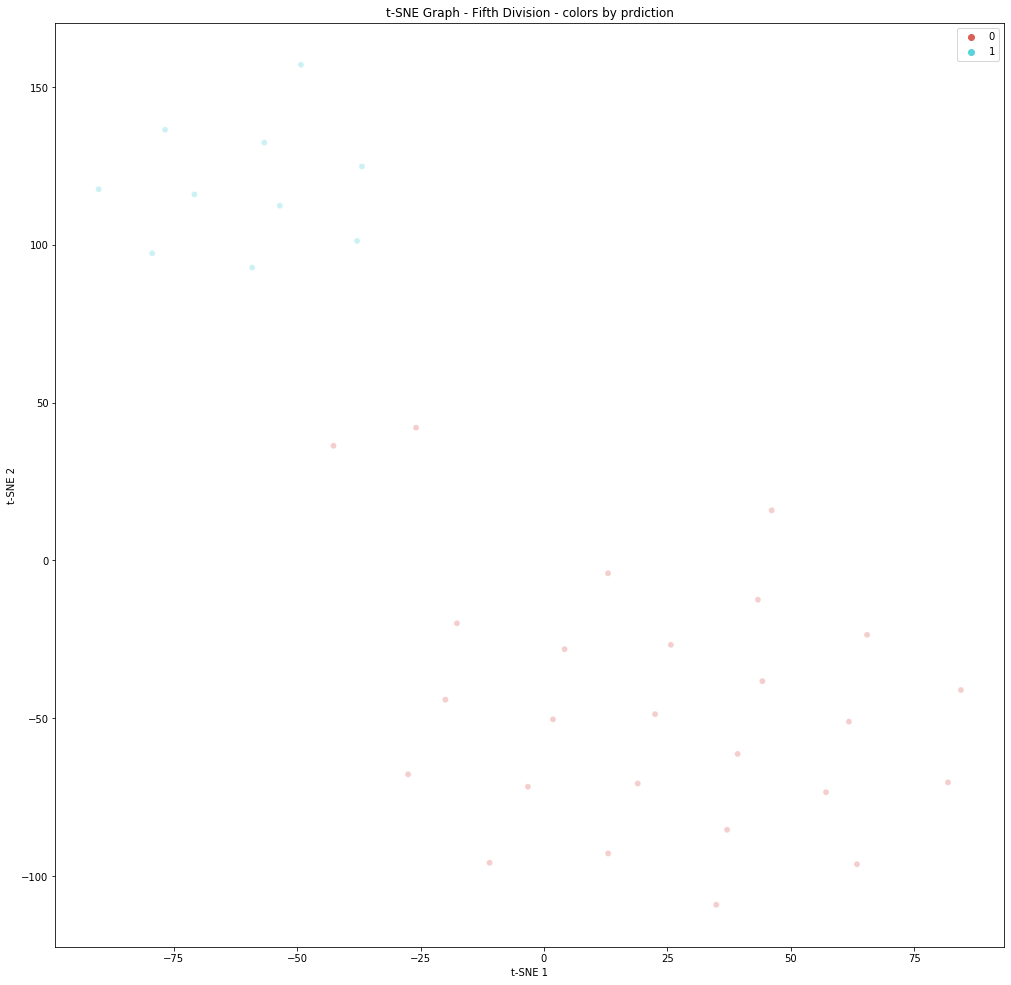

In [49]:
# colors after division to population by age - 

plt.figure(figsize=(17,17))
sns.scatterplot(tsne5_embedding[:,0], tsne5_embedding[:,1], hue=predictions5, palette=sns.color_palette("hls", 2),legend="full",alpha=0.3)

plt.title('t-SNE Graph - Fifth Division - colors by prdiction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('tsne5_by_predictions.png')